<a href="https://colab.research.google.com/github/Zero00502/Sonar-obj-detector/blob/main/Integrated_Object_Detection_Framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Data Loading and Preprocessing

In [83]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sierra022/sonar-imaging-mine-detection")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/sierra022/sonar-imaging-mine-detection/versions/8


In [84]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split

In [85]:
import os
import cv2
import shutil
import numpy as np
import matplotlib.pyplot as plt

# Set the base path based on your folder structure
base_path = '/root/.cache/kagglehub/datasets/sierra022/sonar-imaging-mine-detection/versions/8'

# Define paths for the main train directory
train_images_path = os.path.join(base_path, 'train/train/images')
train_labels_path = os.path.join(base_path, 'train/train/labels')

# Ensure the train directories exist
os.makedirs(train_images_path, exist_ok=True)
os.makedirs(train_labels_path, exist_ok=True)

# Define dataset folders to consolidate into train
folders_to_merge = ['validation', 'test']

# Loop through the folders to merge data into the train folder
for folder in folders_to_merge:
    dataset_path = os.path.join(base_path, folder)

    # Paths for images and labels in the current folder
    images_path = os.path.join(dataset_path, 'images')
    labels_path = os.path.join(dataset_path, 'labels')

    # Move images to the train folder
    if os.path.exists(images_path):
        for image_file in os.listdir(images_path):
            src_image = os.path.join(images_path, image_file)
            dest_image = os.path.join(train_images_path, image_file)
            # Avoid overwriting files with the same name
            if os.path.exists(dest_image):
                print(f"Warning: {dest_image} already exists. Skipping.")
            else:
                shutil.move(src_image, dest_image)

    # Move labels to the train folder
    if os.path.exists(labels_path):
        for label_file in os.listdir(labels_path):
            src_label = os.path.join(labels_path, label_file)
            dest_label = os.path.join(train_labels_path, label_file)
            # Avoid overwriting files with the same name
            if os.path.exists(dest_label):
                print(f"Warning: {dest_label} already exists. Skipping.")
            else:
                shutil.move(src_label, dest_label)

    # Remove the folder after merging
    if os.path.exists(dataset_path):
        shutil.rmtree(dataset_path, ignore_errors=True)
        print(f"Removed folder: {dataset_path}")

# Save the final train path in a variable
final_train_path = os.path.join(base_path, 'train/train')
print(f"Final train folder path: {final_train_path}")


Final train folder path: /root/.cache/kagglehub/datasets/sierra022/sonar-imaging-mine-detection/versions/8/train/train


In [86]:
def load_image(image_path):
    """Loads an image, resizes it, and preprocesses it."""
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found: {image_path}")
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to load image: {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (416, 416))  # Resize to YOLO input size
    image = image / 255.0  # Normalize
    return image


In [87]:
def parse_labels(label_path, img_width, img_height):
    """Parses a label file to generate YOLO-compatible labels."""
    yolo_labels = np.zeros((13, 13, 3, 5))  # 13x13 grid, 3 anchors, 5 outputs

    if not os.path.exists(label_path):
        raise FileNotFoundError(f"Label file not found: {label_path}")

    with open(label_path, 'r') as file:
        for line in file:
            values = line.strip().split()
            class_id = int(values[0])
            x_center = float(values[1]) * img_width
            y_center = float(values[2]) * img_height
            width = float(values[3]) * img_width
            height = float(values[4]) * img_height

            # Calculate grid cell position
            grid_x = int(x_center // (img_width / 13))
            grid_y = int(y_center // (img_height / 13))

            # Normalize coordinates relative to grid cell
            x_offset = (x_center % (img_width / 13)) / (img_width / 13)
            y_offset = (y_center % (img_height / 13)) / (img_height / 13)
            norm_width = width / img_width
            norm_height = height / img_height

            # Assign to anchor (use the first anchor for simplicity)
            yolo_labels[grid_y, grid_x, 0, :] = [1, x_offset, y_offset, norm_width, norm_height]
    return yolo_labels


In [88]:
# Example: Load and display one image and its labels
image_path = os.path.join(train_images_path, "0002_2015.jpg")
label_path = os.path.join(train_labels_path, "0002_2015.txt")

# Debugging: Ensure paths are correct
print(f"Image path: {image_path}")
print(f"Label path: {label_path}")

# Load the image and parse the labels
image = load_image(image_path)
img_height, img_width, _ = image.shape
objects = parse_labels(label_path, img_width, img_height)

# Visualize labels on the image
for obj in objects:
    class_id, x1, y1, x2, y2 = obj
    color = (0, 255, 0) if class_id == 0 else (255, 0, 0)
    cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
    cv2.putText(image, f"{class_id}", (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("off")
plt.show()

Image path: /root/.cache/kagglehub/datasets/sierra022/sonar-imaging-mine-detection/versions/8/train/train/images/0002_2015.jpg
Label path: /root/.cache/kagglehub/datasets/sierra022/sonar-imaging-mine-detection/versions/8/train/train/labels/0002_2015.txt


ValueError: too many values to unpack (expected 5)

In [89]:
image_dir = '/root/.cache/kagglehub/datasets/sierra022/sonar-imaging-mine-detection/versions/8/train/train/images'
objects_dir = '/root/.cache/kagglehub/datasets/sierra022/sonar-imaging-mine-detection/versions/8/train/train/labels'

# Prepare data
images = []
labels = []
max_objects = 0

for filename in os.listdir(image_dir):
    if filename.endswith('.jpg') or filename.endswith('.png'):  # Adjust for image extensions
        image_path = os.path.join(image_dir, filename)
        objects_file = os.path.join(objects_dir, filename[:-4] + '.txt')

        if os.path.exists(objects_file):
            img = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Load image in color format
            if img is None:
                raise FileNotFoundError(f"Image file not found or cannot be read: {image_path}")

            # Handle shape based on image type
            if len(img.shape) == 3:
                img_height, img_width, _ = img.shape
            else:
                img_height, img_width = img.shape

            # Parse labels and resize images
            objects = parse_labels(objects_file, img_width, img_height)
            img = cv2.resize(img, (416, 416))  # Resize to consistent size
            images.append(img)
            labels.append(objects)

            # Update max_objects if current image has more annotations
            max_objects = max(max_objects, len(objects))


# Step 2: Binary Classification Model

In [90]:
class YOLODataGenerator(Sequence):
    def __init__(self, image_paths, label_paths, batch_size, img_width=416, img_height=416):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.batch_size = batch_size
        self.img_width = img_width
        self.img_height = img_height

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_images = []
        batch_labels = []

        for i in range(idx * self.batch_size, (idx + 1) * self.batch_size):
            if i >= len(self.image_paths):
                break
            image = load_image(self.image_paths[i])
            label = parse_labels(self.label_paths[i], self.img_width, self.img_height)
            batch_images.append(image)
            batch_labels.append(label)

        return np.array(batch_images), np.array(batch_labels)


In [91]:
for images, labels in train_generator:
    preds = detection_model.predict(images)
    print("Image batch shape:", images.shape)  # Should be (batch_size, 416, 416, 3)
    print("Label batch shape:", labels.shape)  # Should be (batch_size, 13, 13, 3, 5)
    print("Prediction shape:", preds.shape)    # Should match (batch_size, 13, 13, 3, 5)
    break



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Image batch shape: (32, 416, 416, 3)
Label batch shape: (32, 13, 13, 3, 5)
Prediction shape: (32, 13, 13, 3, 5)


# Step 3: Object Detection Model

In [93]:
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Reshape

# Step 1: Collect image and label paths
train_image_dir = '/root/.cache/kagglehub/datasets/sierra022/sonar-imaging-mine-detection/versions/8/train/train/images'
val_image_dir = '/root/.cache/kagglehub/datasets/sierra022/sonar-imaging-mine-detection/versions/8/val/val/images'
train_label_dir = '/root/.cache/kagglehub/datasets/sierra022/sonar-imaging-mine-detection/versions/8/train/train/labels'
val_label_dir = '/root/.cache/kagglehub/datasets/sierra022/sonar-imaging-mine-detection/versions/8/val/val/labels'

# Collect image paths
image_paths_train = [os.path.join(train_image_dir, f) for f in os.listdir(train_image_dir) if f.endswith(('.jpg', '.png'))]
image_paths_val = [os.path.join(val_image_dir, f) for f in os.listdir(val_image_dir) if f.endswith(('.jpg', '.png'))]

# Collect label paths
label_paths_train = [os.path.join(train_label_dir, f.replace('.jpg', '.txt').replace('.png', '.txt')) for f in os.listdir(train_image_dir) if f.endswith(('.jpg', '.png'))]
label_paths_val = [os.path.join(val_label_dir, f.replace('.jpg', '.txt').replace('.png', '.txt')) for f in os.listdir(val_image_dir) if f.endswith(('.jpg', '.png'))]

# Verify paths
assert len(image_paths_train) == len(label_paths_train), "Mismatch in training images and labels"
assert len(image_paths_val) == len(label_paths_val), "Mismatch in validation images and labels"

# Define input
input_layer = Input(shape=(416, 416, 3))

# Downsample the input
x = Conv2D(16, (3, 3), activation="relu", padding="same")(input_layer)
x = MaxPooling2D(pool_size=(2, 2))(x)  # Downsample: 416 -> 208
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)  # Downsample: 208 -> 104
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)  # Downsample: 104 -> 52
x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)  # Downsample: 52 -> 26
x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)  # Downsample: 26 -> 13
x = Conv2D(5 * 3, (1, 1), activation="linear")(x)  # 5 values (obj + bbox) * 3 anchors

# Reshape the output to YOLO format
output_layer = Reshape((13, 13, 3, 5))(x)

# Define the model
detection_model = Model(inputs=input_layer, outputs=output_layer)

# Print model summary to verify output shape
detection_model.summary()


import tensorflow as tf

def yolo_loss(y_true, y_pred):
    # Objectness loss (binary cross-entropy)
    obj_true = y_true[..., 0]  # Shape: (batch_size, 13, 13, 3)
    obj_pred = y_pred[..., 0]  # Shape: (batch_size, 13, 13, 3)
    obj_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(obj_true, obj_pred))

    # Bounding box loss (mean squared error)
    bbox_true = y_true[..., 1:5]  # Shape: (batch_size, 13, 13, 3, 4)
    bbox_pred = y_pred[..., 1:5]  # Shape: (batch_size, 13, 13, 3, 4)
    bbox_loss = tf.reduce_mean(tf.square(bbox_true - bbox_pred))

    # Combine losses
    total_loss = obj_loss + bbox_loss
    return total_loss

detection_model.compile(optimizer="adam", loss=yolo_loss)

# Step 3: Data Generators
train_generator = YOLODataGenerator(image_paths_train, label_paths_train, batch_size=32)
val_generator = YOLODataGenerator(image_paths_val, label_paths_val, batch_size=32)

# Step 4: Train the Model
detection_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20
)


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 416, 416, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 416, 416, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 208, 208, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 208, 208, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 104, 104, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 104, 104, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 52, 52, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_50 (Conv2D)                   │ (None, 26, 26, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 13, 13, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_51 (Conv2D)                   │ (None, 13, 13, 15)          │           3,855 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_11 (Reshape)                 │ (None, 13, 13, 3, 5)        │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 396,463 (1.51 MB)

 Trainable params: 396,463 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - loss: 0.0208 - val_loss: 0.0168
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 404ms/step - loss: 0.0178 - val_loss: 0.0168
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 402ms/step - loss: 0.0186 - val_loss: 0.0168
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 419ms/step - loss: 0.0215 - val_loss: 0.0168
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 435ms/step - loss: 0.0194 - val_loss: 0.0168
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 390ms/step - loss: 0.0199 - val_loss: 0.0168
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 412ms/step - loss: 0.0186 - val_loss: 0.0168
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 408ms/step - loss: 0.0195 - val_loss: 0.0168
Epoch 9/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 451ms/step - loss: 0.0199 - val_loss: 0.0168
Epoch 10/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 409ms/step - loss: 0.0203 - val_loss: 0.0168
Epoch 11/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 406ms/step - loss: 0.0202 - val_loss: 0.0168
Epoch 12/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 22s 4

# Step 4: Validation and Visualization

In [112]:
def postprocess_predictions(predictions, confidence_threshold=0.5):
    """
    Filters predictions and converts normalized coordinates to pixel values.

    Args:
        predictions (np.array): Raw predictions from the model.
                                Shape: (grid_size, grid_size, anchors, 5).
        confidence_threshold (float): Minimum confidence threshold.

    Returns:
        list: Processed predictions in the format:
              [class_id, confidence, x_center, y_center, width, height].
    """
    processed_predictions = []
    grid_size = predictions.shape[0]  # Typically 13x13 or 19x19 for YOLO-like models

    for i in range(grid_size):
        for j in range(grid_size):
            for anchor in range(predictions.shape[2]):  # Iterate over anchors
                pred = predictions[i, j, anchor]
                confidence = pred[0]
                if confidence < confidence_threshold:
                    continue  # Skip low confidence predictions

                # Denormalize bounding box coordinates
                x_center = (j + pred[1]) / grid_size  # Normalize x_center
                y_center = (i + pred[2]) / grid_size  # Normalize y_center
                box_width = pred[3]  # Already normalized
                box_height = pred[4]  # Already normalized

                class_id = 0  # Assuming a single class; adjust for multi-class
                processed_predictions.append([class_id, confidence, x_center, y_center, box_width, box_height])

    return processed_predictions


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


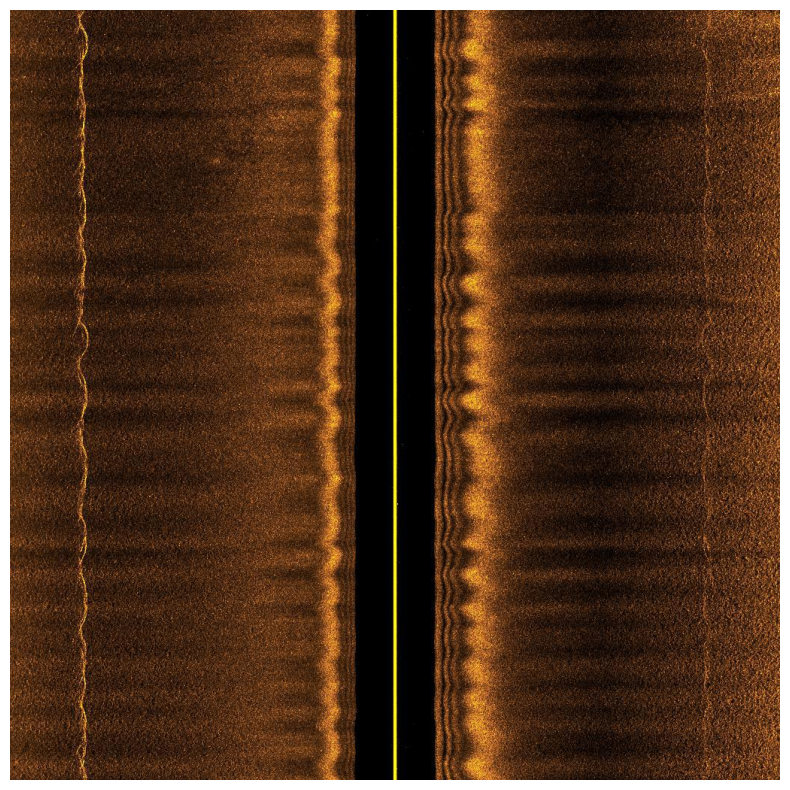

In [124]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Randomly pick an image from the dataset
def pick_random_image(image_dir):
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]
    if not image_files:
        raise FileNotFoundError("No images found in the directory.")
    return os.path.join(image_dir, random.choice(image_files))

# Load label file and convert to bounding box coordinates
def load_label(label_path, img_width, img_height):
    labels = []
    with open(label_path, 'r') as file:
        for line in file:
            values = line.strip().split()
            class_id = int(values[0])
            x_center = float(values[1]) * img_width
            y_center = float(values[2]) * img_height
            box_width = float(values[3]) * img_width
            box_height = float(values[4]) * img_height

            x1 = int(x_center - box_width / 2)
            y1 = int(y_center - box_height / 2)
            x2 = int(x_center + box_width / 2)
            y2 = int(y_center + box_height / 2)

            labels.append([class_id, x1, y1, x2, y2])
    return labels

# Calculate Intersection over Union (IoU)
def calculate_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union = box1_area + box2_area - intersection
    return intersection / union if union > 0 else 0

# Visualize detections and ground truth
def visualize_detections(image_path, predictions, ground_truths, class_labels, confidence_threshold=0.5):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, _ = image.shape

    # Draw predicted boxes
    for prediction in predictions:
        class_id, confidence, x_center, y_center, box_width, box_height = prediction
        if confidence < confidence_threshold:
            continue

        x1 = int((x_center - box_width / 2) * width)
        y1 = int((y_center - box_height / 2) * height)
        x2 = int((x_center + box_width / 2) * width)
        y2 = int((y_center + box_height / 2) * height)

        color = (0, 255, 0)  # Green for predictions
        label = f"{class_labels[class_id]} ({confidence:.2f})"

        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Draw ground truth boxes
    for truth in ground_truths:
        class_id, x1, y1, x2, y2 = truth
        color = (255, 0, 0)  # Red for ground truth
        label = f"Ground Truth: {[class_id]}"

        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

# Main function for validation
image_dir = "/root/.cache/kagglehub/datasets/sierra022/sonar-imaging-mine-detection/versions/8/val/val/images"
label_dir = "/root/.cache/kagglehub/datasets/sierra022/sonar-imaging-mine-detection/versions/8/val/val/labels"
class_labels = {0: "Mine"}  # Add more classes as needed

# Randomly pick an image and its label
random_image_path = pick_random_image(image_dir)
label_path = os.path.join(label_dir, os.path.splitext(os.path.basename(random_image_path))[0] + ".txt")

# Load and preprocess the image
test_image = load_image(random_image_path)
test_image_batch = np.expand_dims(test_image, axis=0)

# Predict bounding boxes
predictions = detection_model.predict(test_image_batch)[0]
processed_predictions = postprocess_predictions(predictions)

# Load ground truth labels
ground_truths = load_label(label_path, img_width=416, img_height=416)

# Visualize predictions and ground truth
visualize_detections(random_image_path, processed_predictions, ground_truths, class_labels)

# Validate predictions against ground truth using IoU
for ground_truth in ground_truths:
    gt_box = ground_truth[1:]  # Extract bounding box coordinates
    for prediction in processed_predictions:
        pred_box = [
            int((prediction[2] - prediction[4] / 2) * 416),
            int((prediction[3] - prediction[5] / 2) * 416),
            int((prediction[2] + prediction[4] / 2) * 416),
            int((prediction[3] + prediction[5] / 2) * 416),
        ]
        iou = calculate_iou(gt_box, pred_box)
        print(f"IoU between GT box {gt_box} and Pred box {pred_box}: {iou:.2f}")
